## Polinomio auto regressivo
Se tem np polos, significa que precisa de np pontos anteriores.\
O $z^{-d}$ é o atraso de transporte \
Função custo possível:
$$J = MSE+\lambda\sum numero de parametros$$
## Estimador de Markov
Estimador dos minimos quadrados ponderados
$$J=[Y - \Phi\hat{\Theta}]^TW[Y - \Phi\hat{\Theta}]$$

In [1]:
import numpy as np
import seaborn as sb
y = np.arange(100)[::-1]+np.random.normal(size=100)
u = y*-1+np.random.normal(size=100)
n = 2
amostras = len(y)
Phi = np.column_stack((y[n-2:amostras-2],y[n-1:amostras-1],y[n:],u[n-2:amostras-2],u[n-1:amostras-1],u[n:]))
Phi.shape
theta = np.linalg.inv(Phi.T.dot(Phi)).dot(Phi.T).dot(y[n:])
y_hat = np.sum(Phi*theta.T,axis=1)
np.sum((y_hat-y[n:])**2)
def lsqrt_memoria(n, u, y):
    amostras = len(u)
    M = np.column_stack((y[n-2:amostras-2],y[n-1:amostras-1],y[n:],u[n-2:amostras-2],u[n-1:amostras-1],u[n:]))
    y = np.array(y)
    theta = np.linalg.inv(M.T.dot(M)).dot(M.T).dot(y[n:])
    y_hat = np.sum(M*theta.T,axis=1)
    return y_hat
y_hat = lsqrt_memoria(2,u,y)
np.sum((y[n:]-y_hat)**2)

3.1103816242219027e-18

In [2]:
# Estimador dos mínimos quadrados não-recursivo (em batelada)
# Processo de segunda ordem (2 pólos e 2 zeros)
#Bibliotecas usadas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

#Importa um arquivo com os dados de saída
with open('data/robot_arm.csv','r') as f:
    data = np.loadtxt(f,delimiter=';')
    # data = data[10:]

print('Método dos mínimos quadrados em batelada')
u = data[:,0] # Como os dados são sequênciais, é gerado uma sequência de números
y = data[:,1] # Salva os dados de saídas
print(f'Número de pontos: {u.size}')

Método dos mínimos quadrados em batelada
Número de pontos: 1024


In [3]:
def gerar_coeficientes(na, nb, u, y):
    deep = max(na, nb)
    numparametros = na+nb
    npts = u.size
    phi = np.ones([npts, numparametros]) # Inicia a matriz Phi para 4 parametros

    work_y = np.append([y[0]]*deep,y[1:])
    work_u = np.append([u[0]]*deep,u[1:])

    for j in range(npts): # Loop para preencher a matriz Phi
        new_phi = []
        for i in range(na):
            new_phi.append(-work_y[max(j-i,0)])
        for i in range(nb):
            new_phi.append(work_u[max(j-i,0)])
        phi[j] = new_phi
    
    theta = np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(y) # Calcula os parametros através de operações matriciais
    return theta

In [4]:
def gerar_yest_n(na, nb, u, y, theta):
    # Inicia a matriz de valores n passos a frente para ser preenchida]
    deep = max(na, nb)
    numparametros = na+nb
    npts = u.size
    yest_n = np.ones(npts)
    yest_n[:deep] = y[:deep] # Preenche os n pontos iniciais

    # A partir do n ponto, calcula o valor da saída conforme os parametros estimados
    yest_u_z = np.ones(numparametros)
    for t in range(deep,npts):

        for i in range(na):
            j = i+1
            yest_u_z[i] = -yest_n[t-j]

        for i in range(na,na+nb):
            j = i+1-na
            yest_u_z[i] = u[t-j]

        # Previsão de n passos a frente
        yest_n[t] = np.sum(theta*yest_u_z)
    return yest_n

In [5]:
def gerar_yest_1(na, nb, u, y, theta):
    # Inicia a matriz de valores n passos a frente para ser preenchida
    deep = max(na, nb)
    numparametros = na+nb
    npts = u.size
    yest_1 = np.ones(npts)
    yest_1[:deep] = y[:deep] # Preenche os n pontos iniciais

    # A partir do n ponto, calcula o valor da saída conforme os parametros estimados
    yest_u_z = np.ones(numparametros)
    for t in range(deep,npts):

        for i in range(na):
            j = i+1
            yest_u_z[i] = -y[t-j]

        for i in range(na,na+nb):
            j = i+1-na
            yest_u_z[i] = u[t-j]

        # Previsão de um passo a frente
        yest_1[t] = np.sum(theta*yest_u_z)
    return yest_1

In [6]:
def gerar_dados(na, nb, u, y):
    theta = gerar_coeficientes(na, nb, u, y)
    yest_n = gerar_yest_n(na, nb, u, y, theta)
    yest_1 = gerar_yest_1(na, nb, u, y, theta)
    return yest_1, yest_n

In [7]:
from itertools import combinations_with_replacement
combinacoes = list(combinations_with_replacement(range(1,4),2))

In [8]:
min_MSE = 10000

for na, nb in combinacoes:
    yest_1, yest_n = gerar_dados(na, nb, u, y)
    deep = max(na, nb)
    npts = u.size

    MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
    print(f'na-nb: {na}-{nb}')
    # Mean Squared Error (MSE) – objetivo é um menor MSE
    print(f'MSE 1: {MSE_1:0.2f}')
    MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
    if MSE_n >= 1000:
        MSE_n = np.inf
    print(f'MSE n: {MSE_n:0.2f}')
    
    if min_MSE > MSE_1:
        min_MSE = MSE_1
        ns = (na,nb)
    
for nb, na in combinacoes:
    yest_1, yest_n = gerar_dados(na, nb, u, y)
    deep = max(na, nb)
    npts = u.size

    MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
    print(f'na-nb: {na}-{nb}')
    # Mean Squared Error (MSE) – objetivo é um menor MSE
    print(f'MSE 1: {MSE_1:0.2f}')
    MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
    print(f'MSE n: {MSE_n:0.2f}')
    
    if min_MSE > MSE_1:
        min_MSE = MSE_1
        ns = (na,nb)

print(ns)
print(min_MSE)

na-nb: 1-1
MSE 1: 0.04
MSE n: 0.11
na-nb: 1-2
MSE 1: 0.04
MSE n: 0.07
na-nb: 1-3
MSE 1: 0.07
MSE n: 0.08
na-nb: 2-2
MSE 1: 0.00
MSE n: 0.08
na-nb: 2-3
MSE 1: 0.04
MSE n: inf
na-nb: 3-3
MSE 1: 0.04
MSE n: inf
na-nb: 1-1
MSE 1: 0.04
MSE n: 0.11
na-nb: 2-1
MSE 1: 0.00
MSE n: 0.08
na-nb: 3-1
MSE 1: 0.04
MSE n: inf
na-nb: 2-2
MSE 1: 0.00
MSE n: 0.08
na-nb: 3-2
MSE 1: 0.04
MSE n: inf
na-nb: 3-3
MSE 1: 0.04
MSE n: inf
(2, 2)
0.0006582295506017557


/tmp/ipykernel_587/2757883442.py:12: RuntimeWarning: overflow encountered in square
  MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
/tmp/ipykernel_587/2757883442.py:30: RuntimeWarning: overflow encountered in square
  MSE_n = np.sum((y-yest_n)**2)/(npts-deep)


MSE 1: 0.00
MSE n: 0.08


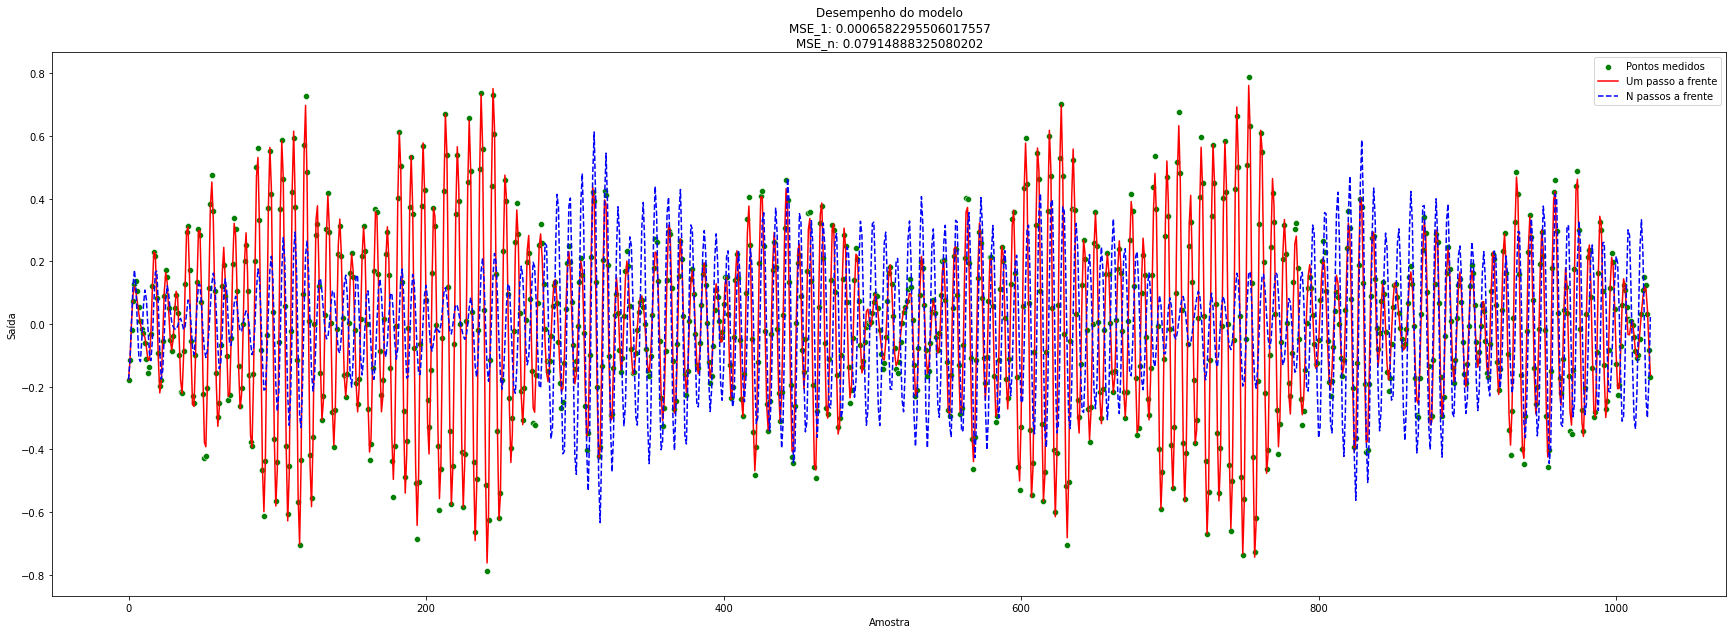

In [9]:
na, nb = 2, 2
yest_1, yest_n = gerar_dados(na, nb, u, y)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
MSE_n = np.sum((y-yest_n)**2)/(npts-deep)

print(f'MSE 1: {MSE_1:0.2f}')
print(f'MSE n: {MSE_n:0.2f}')
t = np.arange(y.size)
# Plota a figura
plt.figure(figsize = (30,10))
sb.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
#sb.barplot(x=t,y=np.abs(y-yest_1),color='purple')
sb.lineplot(x=t,y=yest_1,color='red',linestyle='-',label='Um passo a frente')
sb.lineplot(x=t,y=yest_n,color='blue',linestyle='--',label='N passos a frente')
plt.title(f'Desempenho do modelo\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
#plt.legend(labels=["Real","Um passo a frente","N passos a frente"])
plt.xlabel('Amostra')
plt.ylabel('Saída')
plt.show()
plt.close()
